In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
from src.bus_functions import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.geometry import Point
calculated_pair_path = "data/node_pairs.parquet"
pd.set_option('display.max_columns', None)
from plotnine import *
from shapely.geometry import LineString, Point

In [2]:
buses_weather = gpd.read_parquet("/home/canyon/Bus-Weather-Impacts/data/buses_with_segmented_storm.parquet").query("time_diff_seconds < 1000 & speed_osm < 70").to_crs(4326)

In [3]:
buses_weather["speed_osm"].describe()

count   13142470.00
mean           7.22
std            5.94
min            0.01
25%            3.12
50%            5.88
75%            9.51
max           69.98
Name: speed_osm, dtype: float64

In [4]:
route_speeds = buses_weather.groupby(["route_short", "from", "to"])["speed_osm"].mean().reset_index()

In [5]:
route_speeds.groupby("route_short")["speed_osm"].describe(percentiles = [0.1, .25, .5, .75, .90]).reset_index().sort_values("50%")

,route_short,count,mean,std,min,10%,25%,50%,75%,90%,max
141,M23+,36.00,2.75,1.49,0.56,0.96,1.73,2.59,3.34,4.53,7.57
157,M79+,56.00,5.60,6.65,0.11,1.49,2.12,3.08,4.99,12.41,24.86
161,M96,40.00,3.58,1.59,1.21,1.91,2.33,3.12,4.49,5.58,7.84
22,B39,13.00,2.98,1.02,1.21,1.93,2.03,3.31,3.45,4.10,4.70
152,M57,65.00,3.62,1.84,0.79,1.62,2.19,3.43,4.39,6.39,7.54
...,...,...,...,...,...,...,...,...,...,...,...
146,M35,114.00,17.21,10.66,1.04,3.41,7.87,15.77,27.35,29.61,39.85
253,QM2,699.00,25.26,20.53,1.01,5.03,7.38,15.95,40.05,59.15,65.43
119,J90,209.00,22.16,7.05,9.27,13.94,17.11,20.59,27.30,30.94,45.93
264,QM4,257.00,24.61,14.94,2.53,5.04,8.32,37.36,37.36,40.31,40.31


In [6]:
buses_weather['date'] = pd.to_datetime(buses_weather['timestamp']).dt.date
buses_weather['hour'] = pd.to_datetime(buses_weather['timestamp']).dt.hour

In [7]:
borough_map = {
    'M': 'Manhattan',
    'BX': 'Bronx',
    'B': 'Brooklyn',
    'Q': 'Queens',
    'S': 'Staten Island',
    'X': 'Cross-borough'
}

def get_borough(route):
    for prefix, borough in borough_map.items():
        if route.startswith(prefix):
            return borough
    return 'Unknown'  # In case the route doesn't match any known prefix

# Apply the function to create the new column
buses_weather['borough'] = buses_weather['route_short'].apply(get_borough)

borough_order = ["Bronx", "Manhattan", "Brooklyn", "Cross-borough", "Queens", "Staten Island"]

# Convert the 'borough' column to an ordered categorical type
buses_weather["borough"] = pd.Categorical(buses_weather["borough"], categories=borough_order, ordered=True)


In [8]:
# Ensure the 'date' column is in datetime format
buses_weather['date'] = pd.to_datetime(buses_weather['date'])

# Then apply the mask and flood_indicator logic
buses_weather['flood_indicator'] = "Not flooding"
mask = (
    (buses_weather['date'].dt.month == 9) &
    (buses_weather['date'].dt.day == 29) &
    (buses_weather['hour'] > 10) &
    (buses_weather['hour'] < 20)
)
buses_weather.loc[mask, 'flood_indicator'] = "Flooding"

In [9]:
comp = buses_weather.query("flood_indicator == 'Flooding' or (date.dt.day in [28, 22] and hour > 10 and hour < 20)")

In [10]:
comp_routes = comp.groupby(["route_short", "flood_indicator", "borough"])["speed_osm"].mean().reset_index().dropna()

/tmp/ipykernel_626/2769445391.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [11]:
comp_routes = comp_routes.pivot(index = ["route_short", "borough"], columns = "flood_indicator", values = "speed_osm").reset_index()

In [12]:
comp_routes["flood_ratio"] = comp_routes["Flooding"] / comp_routes["Not flooding"] 

In [13]:
comp_routes.groupby("borough")["flood_ratio"].describe()

/tmp/ipykernel_626/4112207385.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,count,mean,std,min,25%,50%,75%,max
borough,,,,,,,,
Bronx,45.00,1.05,0.38,0.26,0.80,1.03,1.25,2.13
Manhattan,20.00,0.93,0.28,0.41,0.81,0.89,1.06,1.62
Brooklyn,48.00,0.95,0.37,0.17,0.72,0.90,1.17,1.88
Cross-borough,5.00,0.98,0.43,0.67,0.68,0.78,1.08,1.70
Queens,89.00,1.14,0.64,0.45,0.87,1.02,1.20,5.65
Staten Island,44.00,0.98,0.37,0.11,0.76,1.00,1.21,1.80


In [15]:
comp_points = comp.groupby(["flood_indicator", "from", "to"])["speed_osm"].mean().reset_index().pivot(index = ["from", "to"], columns = "flood_indicator", values = "speed_osm").reset_index()


In [16]:
comp_points

flood_indicator,from,to,Flooding,Not flooding
0,42421728.00,42435337.00,NaN,7.10
1,42421741.00,42432756.00,NaN,5.88
2,42421745.00,11803957852.00,NaN,4.42
3,42421749.00,42431118.00,NaN,15.79
4,42421751.00,42432764.00,NaN,10.65
...,...,...,...,...
31280,11942707043.00,1544628310.00,NaN,7.67
31281,11947966038.00,42463694.00,NaN,9.99
31282,11947966038.00,5882645209.00,NaN,34.60
31283,11963258425.00,5329702160.00,NaN,6.49


In [51]:
comp_median = gpd.GeoDataFrame(comp.groupby(["flood_indicator", "geometry"])["speed_osm"].median().reset_index())

In [52]:
comp_median

,flood_indicator,geometry,speed_osm
0,Flooding,POINT (-74.25208 40.50760),4.02
1,Flooding,POINT (-74.25034 40.50805),2.16
2,Flooding,POINT (-74.24433 40.50430),3.69
3,Flooding,POINT (-74.24164 40.50484),0.94
4,Flooding,POINT (-74.23739 40.51352),6.28
...,...,...,...
13576,Not flooding,POINT (-73.74565 40.60271),4.99
13577,Not flooding,POINT (-73.74562 40.60260),8.62
13578,Not flooding,POINT (-73.74541 40.60196),8.89
13579,Not flooding,POINT (-73.74504 40.60020),6.32


In [53]:
ntas = gpd.read_file("https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson")
ntas = ntas[["ntaname", "boroname", "geometry"]]
comp_nta = gpd.sjoin(comp_median, ntas, how="inner", op="within")

/home/canyon/.local/share/virtualenvs/TOP-Sprint-lAvM2-mU/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [54]:
comp_nta = comp_nta.groupby(["ntaname", "flood_indicator"])["speed_osm"].median().reset_index().pivot(index = ["ntaname"], columns = "flood_indicator", values = "speed_osm").reset_index().dropna()

In [55]:
comp_nta

flood_indicator,ntaname,Flooding,Not flooding
1,Alley Pond Park,11.28,11.37
2,Annadale-Huguenot-Prince's Bay-Woodrow,6.85,8.23
3,Arden Heights-Rossville,11.29,9.82
4,Astoria (Central),3.79,4.06
5,Astoria (East)-Woodside (North),5.74,5.74
...,...,...,...
236,Williamsburg,3.12,4.05
237,Windsor Terrace-South Slope,4.49,4.94
238,Woodhaven,4.11,4.10
239,Woodlawn Cemetery,8.84,3.76


In [56]:
comp_nta["flood_ratio"] = comp_nta["Flooding"] / comp_nta["Not flooding"]

<Axes: >

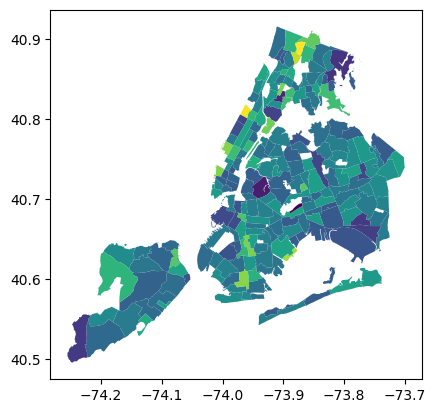

In [63]:
ntas.merge(comp_nta.sort_values("flood_ratio")).plot("flood_ratio")